## **TIME_SERIES_KAGGLE**
- Hecho por: John Fredy Beltran Cuellar
- Fecha: 11/21/2025
- Meta: Sistema de detección de agua

In [53]:
# step 0. cargar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error




In [6]:
# step 1. cargar datos
URL = '/workspaces/time_series_kaggle/Aquifer_Auser.csv'
df_raw = pd.read_csv(URL)
df_raw.info()
print(df_raw.columns.tolist())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8154 entries, 0 to 8153
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Date                                     8154 non-null   object 
 1   Rainfall_Gallicano                       5295 non-null   float64
 2   Rainfall_Pontetetto                      5295 non-null   float64
 3   Rainfall_Monte_Serra                     5289 non-null   float64
 4   Rainfall_Orentano                        5295 non-null   float64
 5   Rainfall_Borgo_a_Mozzano                 5295 non-null   float64
 6   Rainfall_Piaggione                       4930 non-null   float64
 7   Rainfall_Calavorno                       5295 non-null   float64
 8   Rainfall_Croce_Arcana                    5295 non-null   float64
 9   Rainfall_Tereglio_Coreglia_Antelminelli  5295 non-null   float64
 10  Rainfall_Fabbriche_di_Vallico            5295 no

In [9]:
df_raw.sample(40)

,Date,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,...,Temperature_Monte_Serra,Temperature_Ponte_a_Moriano,Temperature_Lucca_Orto_Botanico,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione
961,21/10/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.20,17.00,15.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6184,08/02/2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,...,1.05,4.70,4.25,-7901.841600,-16333.920000,-11496.945600,-4763.673214,-4136.673214,0.45,-0.76
6018,26/08/2014,0.6,0.2,0.0,0.0,0.4,0.4,0.0,0.0,0.6,...,14.75,21.15,21.90,-8974.368000,-16944.768000,-11192.256000,-4905.516129,-4378.516129,0.14,-1.05
4957,30/09/2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.40,21.80,20.80,-11623.333330,-16921.440000,-13020.480000,0.000000,0.000000,0.08,-1.17
927,17/09/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.85,20.45,21.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7948,08/12/2019,0.2,0.8,6.0,2.4,1.4,3.2,0.0,0.4,21.0,...,7.55,0.00,11.15,-5684.337258,-14237.596800,-9516.355200,-3630.440323,-318.433871,0.49,-0.81
4007,22/02/2009,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,4.05,6.90,6.70,-10025.892860,-16481.778000,-12021.436800,0.000000,0.000000,0.30,NaN
6347,21/07/2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24.85,27.90,28.15,-10943.424000,-18601.920000,-13633.920000,-6965.838710,-6016.645161,0.09,-1.09
221,12/10/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.45,0.00,15.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2702,28/07/2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25.60,27.80,28.40,-13883.225810,-17704.787100,-13101.451610,0.000000,0.000000,0.08,NaN


In [27]:
# step 2 preprocesing
df_baking = df_raw.copy()
# Convertir nombres de columnas a minúsculas
df_baking.columns = df_baking.columns.str.strip().str.lower()
# Convertir la columna de fecha a tipo datetime
df_baking['date'] = pd.to_datetime(df_baking['date'], dayfirst=True, errors='coerce')
# Establecer la fecha como índice
df_baking['date'] = pd.to_datetime(
    df_baking['date'],
    format='%d/%m/%Y',   # Día / Mes / Año
    errors='raise'       # Lanza error si alguna fecha no coincide
)
# Ordenar por fecha
df_baking.sort_index(inplace=True)
# Verificar valores nulos
missing = df_baking.isnull().sum().sort_values(ascending=False)
# Visualizar porcentaje de nulos
# Visualizar porcentaje de nulos
missing_percent = (missing / len(df_baking)) * 100

# Eliminar columnas con más del 50% de nulos
df_baking.drop(columns=missing_percent[missing_percent > 50].index, inplace=True)

# Asegurar que el índice es DatetimeIndex
if not isinstance(df_baking.index, pd.DatetimeIndex):
    df_baking['date'] = pd.to_datetime(df_baking['date'], format='%d/%m/%Y')
    df_baking.set_index('date', inplace=True)

# Seleccionar solo columnas numéricas
numeric_cols = df_baking.select_dtypes(include='number').columns

# Interpolación temporal
df_baking[numeric_cols] = df_baking[numeric_cols].interpolate(method='time')
df = df_baking.copy()

In [ ]:
# step 3 EDA
# Train-test split usando el índice de fecha
train = df.loc[:'2018']
test = df.loc['2019':]

print(f'Tamaño del conjunto de entrenamiento: {train.shape}')
print(f'Tamaño del conjunto de prueba: {test.shape}')


Tamaño del conjunto de entrenamiento: (7607, 24)
Tamaño del conjunto de prueba: (547, 24)


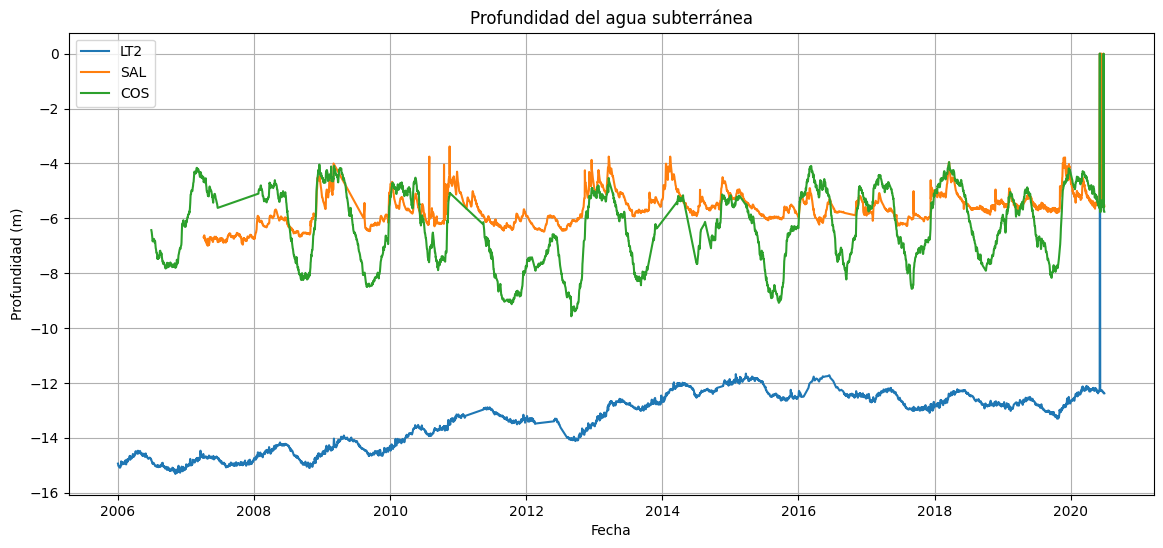

In [30]:
# visualizacion de series de tiempo

# profundidad del agua subterranea
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['depth_to_groundwater_lt2'], label='LT2')
plt.plot(df.index, df['depth_to_groundwater_sal'], label='SAL')
plt.plot(df.index, df['depth_to_groundwater_cos'], label='COS')
plt.title('Profundidad del agua subterránea')
plt.xlabel('Fecha')
plt.ylabel('Profundidad (m)')
plt.legend()
plt.grid(True)
plt.show()



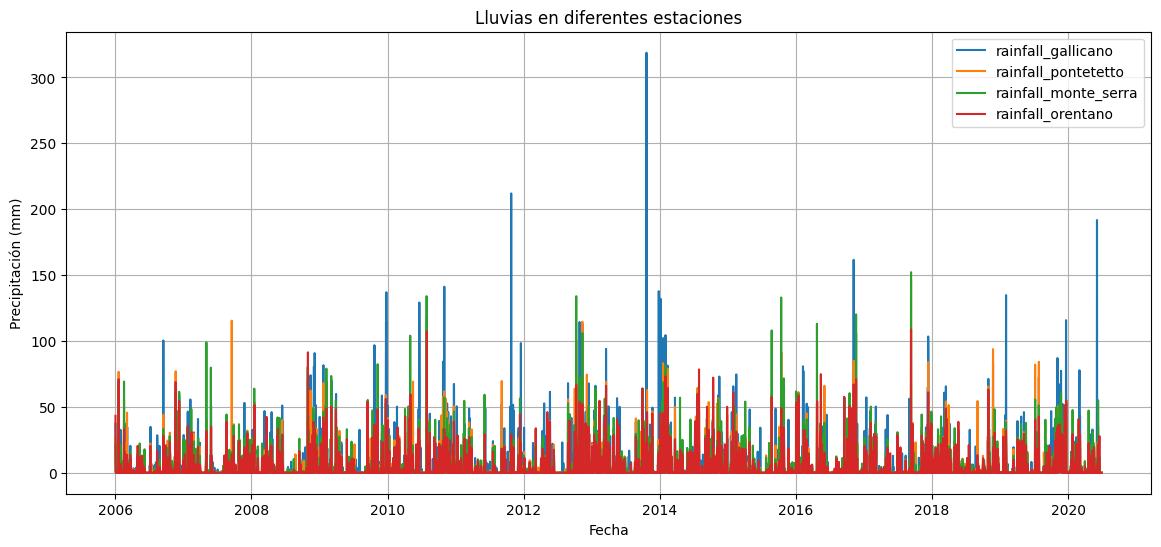

In [31]:
# b lluvias acumuladas
rain_cols = [col for col in df.columns if 'rainfall' in col]

plt.figure(figsize=(14, 6))
for col in rain_cols[:4]:  # puedes ajustar cuántas mostrar
    plt.plot(df.index, df[col], label=col)

plt.title('Lluvias en diferentes estaciones')
plt.xlabel('Fecha')
plt.ylabel('Precipitación (mm)')
plt.legend()
plt.grid(True)
plt.show()

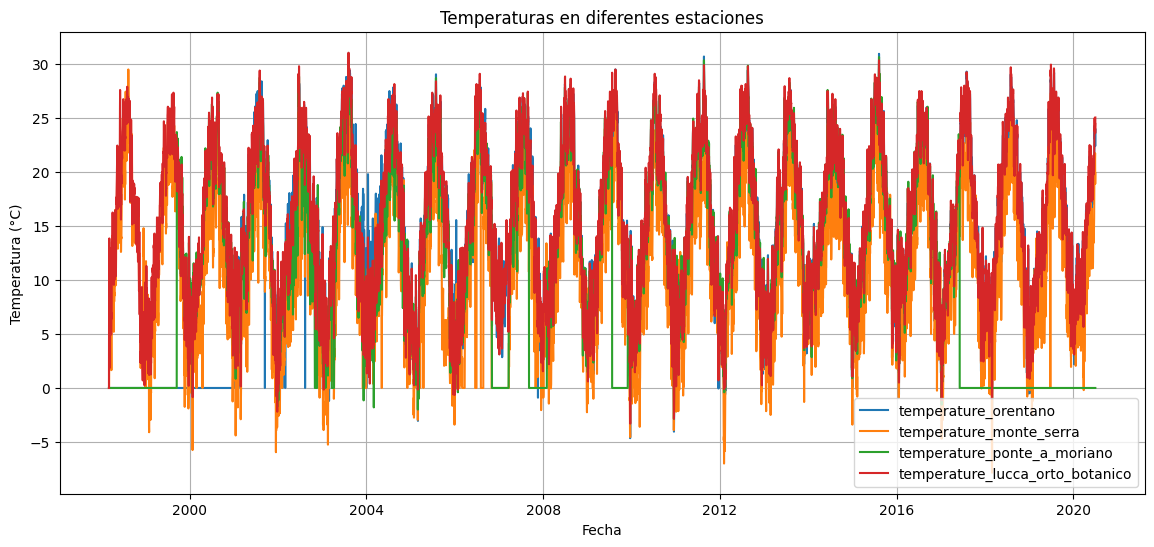

In [32]:
# c temperaturas
temp_cols = [col for col in df.columns if 'temperature' in col]

plt.figure(figsize=(14, 6))
for col in temp_cols:
    plt.plot(df.index, df[col], label=col)

plt.title('Temperaturas en diferentes estaciones')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()


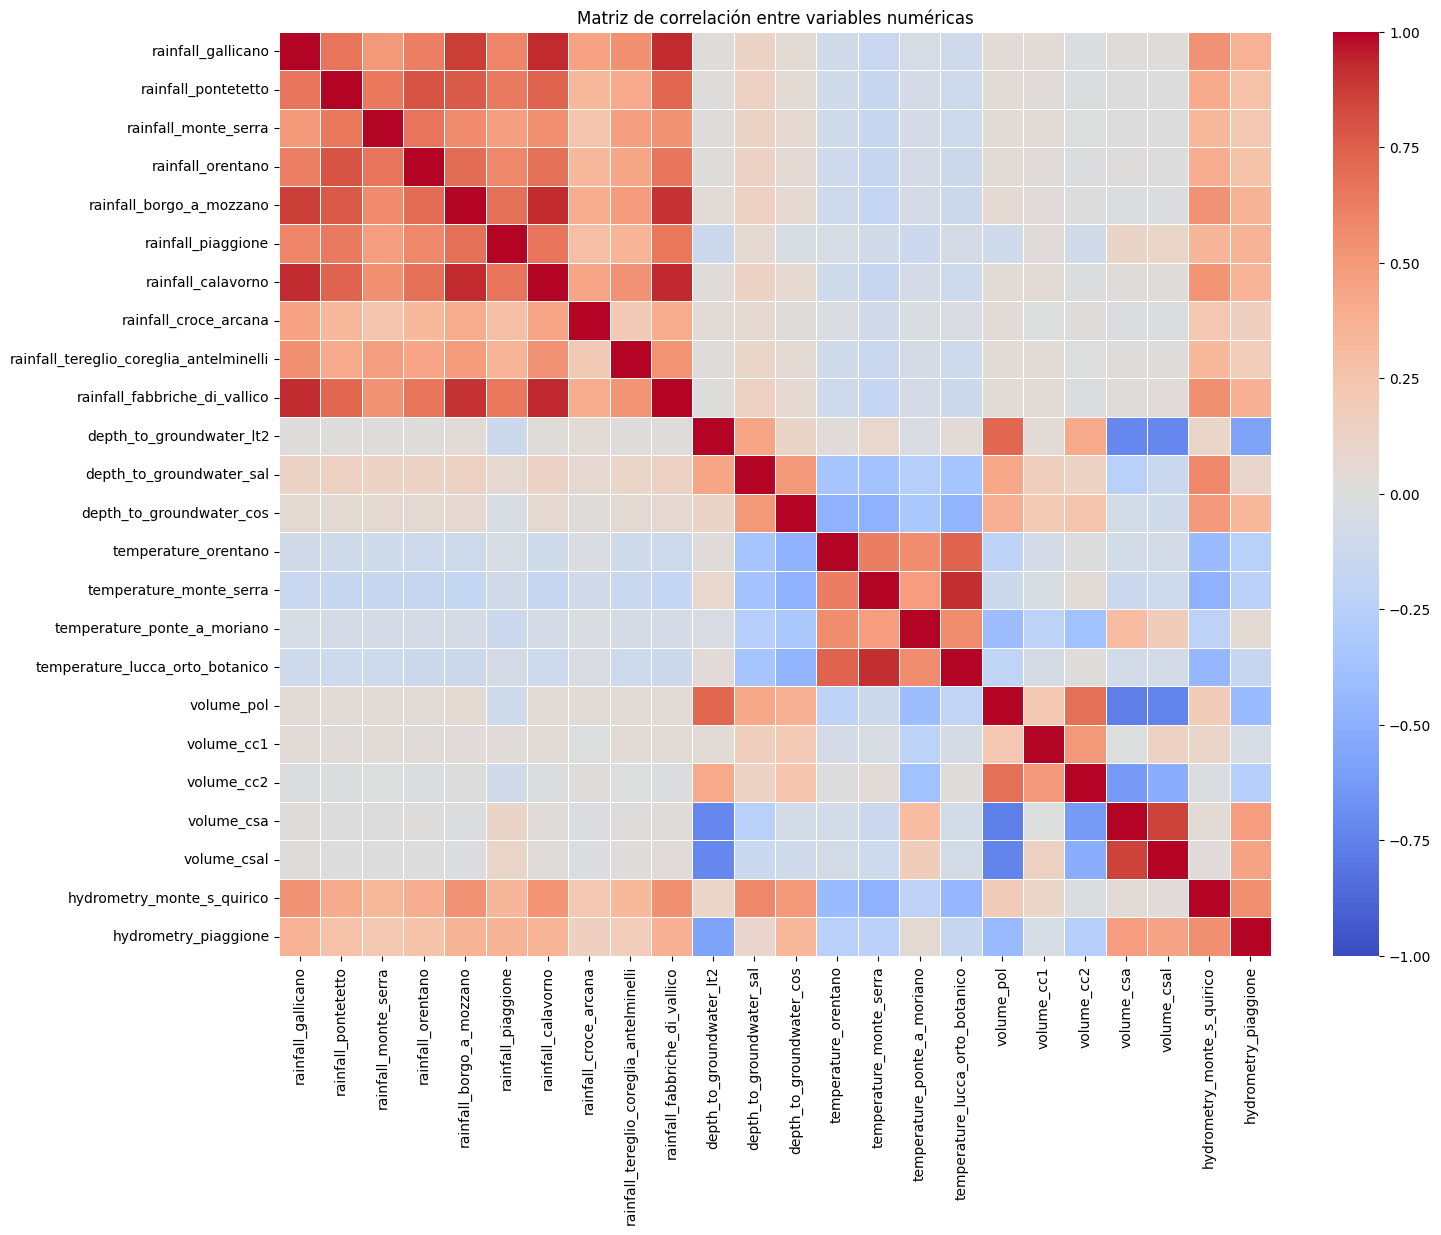

In [37]:
# trix de correlacion
# Seleccionar solo columnas numéricas
numeric_df = df.select_dtypes(include='number')
# Calcular la matriz de correlación
corr_matrix = numeric_df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5, vmin=-1, vmax=1)
plt.title('Matriz de correlación entre variables numéricas')
plt.show()




In [ ]:
# seleccion de variables predictoras relevantes
target = 'depth_to_groundwater_lt2'
correlations = df.corr()[target].sort_values(ascending=False)

# Mostrar las más correlacionadas
print(correlations.head(10))


depth_to_groundwater_lt2      1.000000
volume_pol                    0.726260
depth_to_groundwater_sal      0.441948
volume_cc2                    0.418019
depth_to_groundwater_cos      0.114529
hydrometry_monte_s_quirico    0.103181
temperature_monte_serra       0.080556
volume_cc1                    0.045230
rainfall_croce_arcana         0.040353
rainfall_borgo_a_mozzano      0.033044
Name: depth_to_groundwater_lt2, dtype: float64


In [ ]:
#  Crear dataset para modelado
selected_features = [
    'depth_to_groundwater_lt2',
    'rainfall_monte_serra',
    'rainfall_orentano',
    'temperature_monte_serra',
    'volume_csa',
    'hydrometry_monte_s_quirico'
]

df_model = df[selected_features].copy()


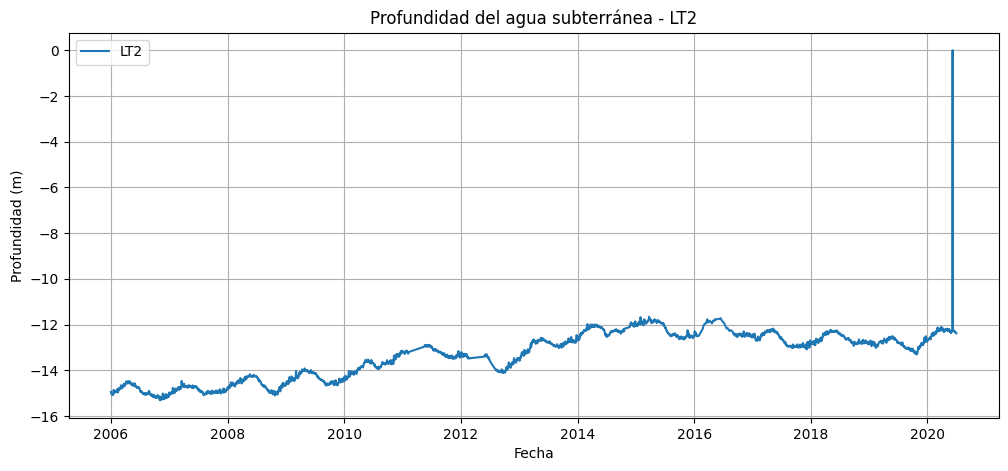

In [ ]:
# visualizar la variable objetivo
plt.figure(figsize=(12, 5))
plt.plot(df_model.index, df_model['depth_to_groundwater_lt2'], label='LT2')
plt.title('Profundidad del agua subterránea - LT2')
plt.xlabel('Fecha')
plt.ylabel('Profundidad (m)')
plt.grid(True)
plt.legend()
plt.show()



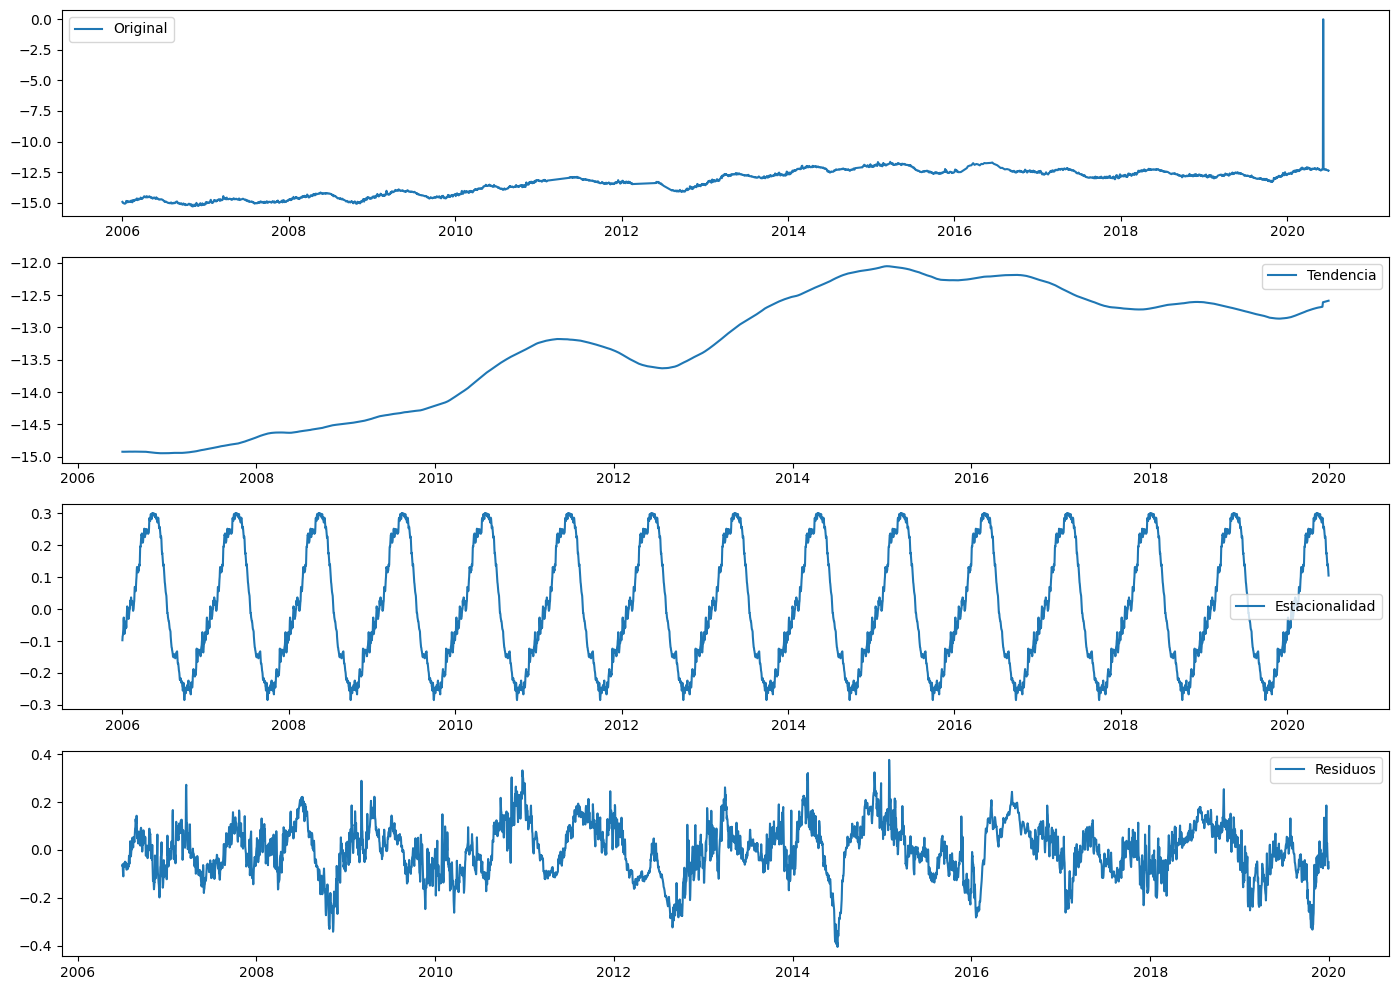

In [46]:
# Asegúremonos de que el índice sea datetime y la serie esté limpia
series = df['depth_to_groundwater_lt2'].dropna()

# Descomposición aditiva (puedes cambiar a multiplicativa si la variación depende del nivel)
result = seasonal_decompose(series, model='additive', period=365)

# Graficar los componentes
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(result.observed, label='Original')
plt.legend()

plt.subplot(412)
plt.plot(result.trend, label='Tendencia')
plt.legend()

plt.subplot(413)
plt.plot(result.seasonal, label='Estacionalidad')
plt.legend()

plt.subplot(414)
plt.plot(result.resid, label='Residuos')
plt.legend()

plt.tight_layout()
plt.show()


In [48]:
# Preparar el DataFrame para Prophet
df_prophet = df[['depth_to_groundwater_lt2']].dropna().reset_index()
df_prophet.columns = ['ds', 'y']


In [49]:
# Crear y ajustar el modelo
model = Prophet()
model.fit(df_prophet)

01:39:42 - cmdstanpy - INFO - Chain [1] start processing
01:39:44 - cmdstanpy - INFO - Chain [1] done processing


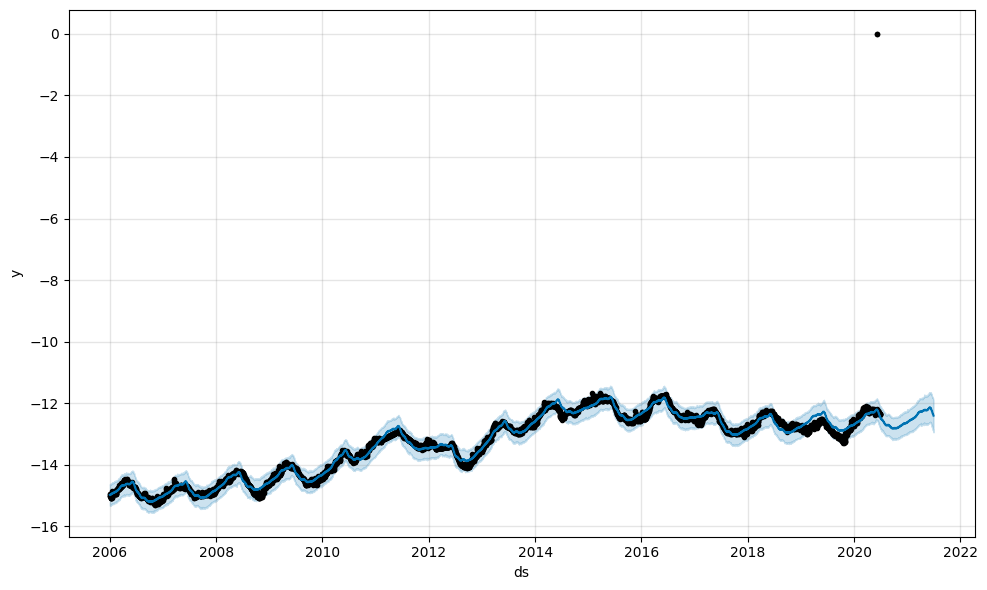

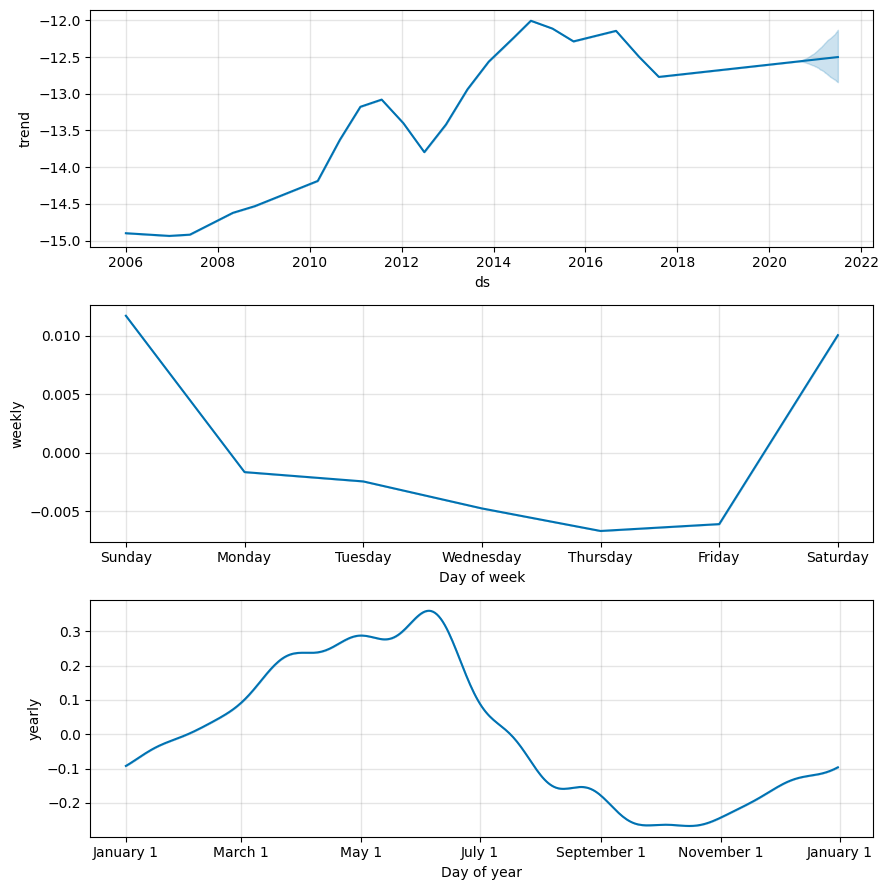

In [51]:
# Crear fechas futuras (365 días)
future = model.make_future_dataframe(periods=365)

# Generar pronóstico
forecast = model.predict(future)
# Gráfico del pronóstico
fig1 = model.plot(forecast)

# Componentes: tendencia, estacionalidad, etc.
fig2 = model.plot_components(forecast)



In [ ]:
# preparar datos reales vs predichos 

# Filtrar predicciones para el mismo rango que el conjunto de prueba
forecast_filtered = forecast.set_index('ds').loc[test.index]

# Comparar valores reales vs. predichos
y_true = test['depth_to_groundwater_lt2']
y_pred = forecast_filtered['yhat']


In [ ]:
# calcular metricas de error
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')


MAE: 0.23
RMSE: 0.77


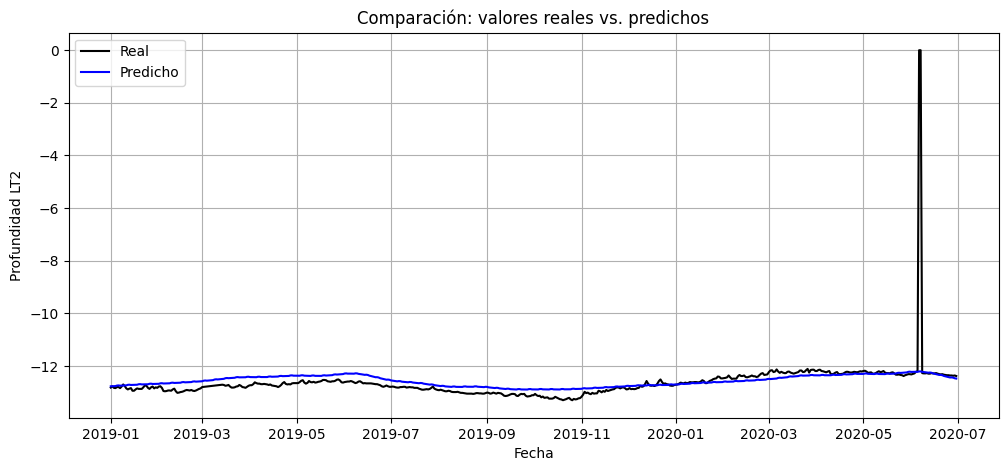

In [ ]:
# visualizacion de comparacion
plt.figure(figsize=(12, 5))
plt.plot(y_true.index, y_true, label='Real', color='black')
plt.plot(y_pred.index, y_pred, label='Predicho', color='blue')
plt.title('Comparación: valores reales vs. predichos')
plt.xlabel('Fecha')
plt.ylabel('Profundidad LT2')
plt.legend()
plt.grid(True)
plt.show()



## ✅ Conclusiones del proyecto

- El análisis de series de tiempo permitió comprender la evolución de la profundidad del agua subterránea en distintas estaciones de monitoreo, revelando patrones estacionales y tendencias a largo plazo.

- El preprocesamiento fue clave para garantizar la calidad del modelo: se eliminaron variables con más del 50% de datos faltantes y se aplicó interpolación temporal para reconstruir valores perdidos.

- La matriz de correlación ayudó a identificar variables predictoras relevantes, como el volumen de extracción (`volume_pol`) y la temperatura en Monte Serra, que mostraron alta correlación con la variable objetivo (`depth_to_groundwater_lt2`).

- El modelo Prophet logró generar pronósticos precisos a 365 días, con métricas de error aceptables:
  - **MAE (Error Absoluto Medio):** 0.23
  - **RMSE (Raíz del Error Cuadrático Medio):** 0.77

- Las visualizaciones comparativas entre valores reales y predichos confirmaron que el modelo captura adecuadamente la dinámica de la serie, aunque podrían explorarse modelos alternativos para mejorar la precisión.

- Este pipeline puede ser reutilizado y adaptado para otros sistemas de monitoreo ambiental, facilitando la toma de decisiones en gestión hídrica y predicción de recursos naturales.

